## Is it a bird?

In [ ]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

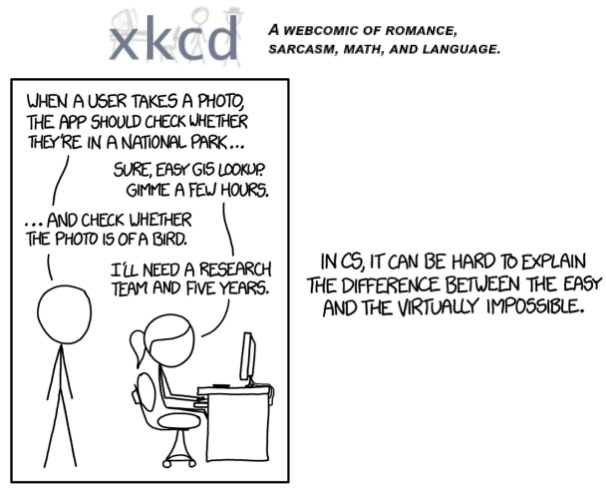

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [ ]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search

In [159]:
from fastcore.all import *

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [7]:
urls = search_images('bird photos', max_images=2)
urls[1]

'http://2.bp.blogspot.com/-LZ4VixDdVoE/Tq0ZhPycLsI/AAAAAAAADDM/OKyayfW-z4U/s1600/beautiful_Birds_wallpapers_pictures_Kingfisher_Lilac+Breasted+Roller+Bird.JPG'

...and then download a URL and take a look at it:

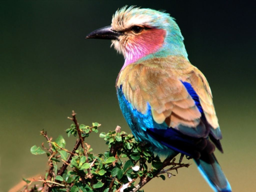

In [8]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[1], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

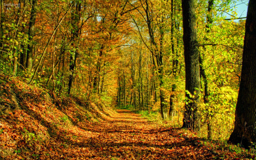

In [9]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:

In [10]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


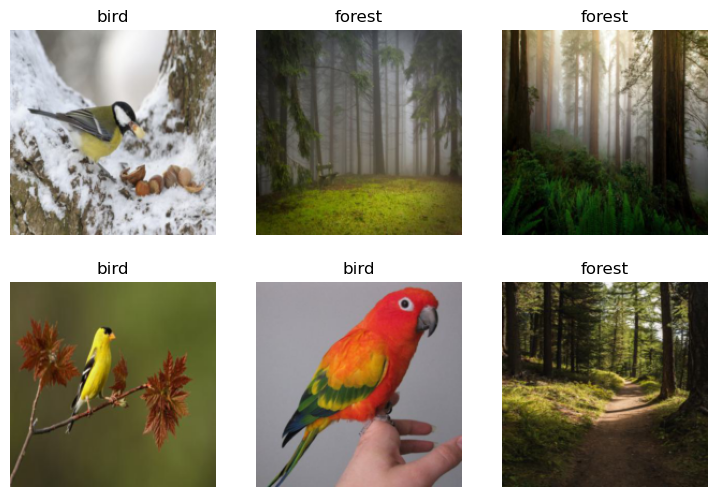

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

c:\Users\Danny\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Danny\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Danny/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:07<00:00, 6.39MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.519526,0.218365,0.052402,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.122661,0.073427,0.026201,00:09
1,0.068240,0.088100,0.026201,00:07
2,0.042116,0.098967,0.021834,00:07


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [14]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.

## Broken Glass Identifier

https://freesound.org/docs/api/
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html

We'll need a bunch of "not glass break" and glass break sounds.

Check sound online at https://freesound.org/s/41348/

In [44]:
import matplotlib.pyplot as plt
import wave
import numpy as np
from pathlib import Path

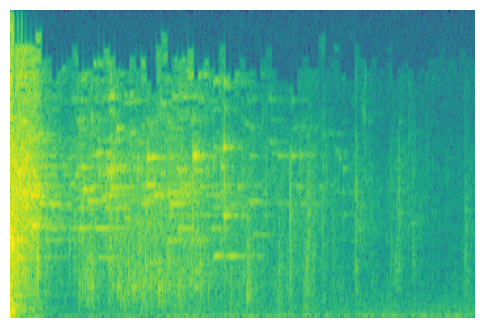

In [48]:
# Get spectrogram from wavefile and save
wave_path = './datasets/glass_break_or_not/glass_break/41348__datasoundsample__glass-shatter.wav'

with wave.open(wave_path, 'r') as sound_file:
    frames = sound_file.readframes(-1)
    sound_info = np.frombuffer(frames, dtype='int32')
    frame_rate = sound_file.getframerate()
    # plt.xlabel('Time [s]')
    # plt.ylabel('Frequency [Hz]')
    plt.figure(figsize=(6,4))
    plt.axis('off')
    plt.specgram(sound_info, Fs=frame_rate)
    plt.savefig(Path(wave_path).parent.joinpath(Path(wave_path).stem + '.png'), bbox_inches='tight')


### Freesound Auth
To get a fresh OAuth2 authorization code, visit this url in browser:
https://freesound.org/apiv2/oauth2/authorize/?client_id=eQd5fsXp2lfwsDeteLN6&response_type=code

Details here: https://freesound.org/docs/api/authentication.html#step-1

Once you have the auth code, retrieve an access token, which can then be used in get requests.

In [95]:
import httpx

client_id = 'eQd5fsXp2lfwsDeteLN6'
# AKA client_secret
api_key = 'Bidwmi9LSrDPMUM2ZnDuwAjFIx6TCsmM8mvpRU8t'
auth_code = 'IDsIV7wsnsl4d9bmO3g9NcuNOmPrVF'

data = {'client_id': client_id, 'client_secret': api_key,
        'grant_type': 'authorization_code', 'code': auth_code}

auth_token_res = httpx.post('https://freesound.org/apiv2/oauth2/access_token/', params=data)
auth_token = auth_token_res.json()['access_token']
auth_token

'ng7LVBLAMHco1oyT5l36ByebthOcSd'

In [137]:
import httpx

api_key = 'Bidwmi9LSrDPMUM2ZnDuwAjFIx6TCsmM8mvpRU8t'
auth_code = '71IROYQ2stmcHdIFZtyst444PWe887'
# curl -H "Authorization: Bearer {{ng7LVBLAMHco1oyT5l36ByebthOcSd}}" 'https://freesound.org/apiv2/sounds/14854/download/'
glass_break_ids = []
glass_break_res = httpx.get('https://freesound.org/apiv2/search/text/?filter=tag:shatter%20type:(wav)&token=' + api_key).json()
# glass_break_res
while glass_break_res['next']:
    glass_break_ids = glass_break_ids + [sound['id'] for sound in glass_break_res['results']]
    glass_break_res = httpx.get(glass_break_res['next'] + '&token=' + api_key).json()

# glass_break_ids

{'count': 365,
 'next': 'https://freesound.org/apiv2/search/text/?&query=&filter=tag:Shatter%20type:(wav)&weights=&page=2',
 'results': [{'id': 34132,
   'name': 'Crackler2 .wav',
   'tags': ['clatter',
    'dry',
    'effect',
    'filter',
    'noise',
    'random',
    'ring-modulation',
    'shatter',
    'synth',
    'vibrato'],
   'license': 'http://creativecommons.org/licenses/by/3.0/',
   'username': 'jobro'},
  {'id': 383995,
   'name': 'rhythmic change jar loop',
   'tags': ['foley',
    'sound',
    'sfx',
    'fx',
    'money',
    'jar',
    'effect',
    'break',
    'glass',
    'shatter',
    'sounddesign',
    'soundeffect',
    'bottle',
    'movie',
    'sound-design',
    'thud',
    'creak',
    'film',
    'sound-effect'],
   'license': 'https://creativecommons.org/licenses/by/4.0/',
   'username': 'ChrisReierson'},
  {'id': 57948,
   'name': 'bottle1.wav',
   'tags': ['air', 'bb', 'glass', 'gun', 'plinking', 'rifle', 'shatter'],
   'license': 'http://creativecomm

In [78]:
# grab all non glass-breaky type sounds
# other_ids_all = [sound['id'] for sound in other_res.json()['results']]
other_ids_not_glass = []
other_res = httpx.get('https://freesound.org/apiv2/search/text/?filter=type:(wav)&token=' + api_key).json()

while other_res['next'] and len(other_ids_not_glass) < 1000:
    for sound in other_res['results']:
        for tag in sound['tags']:
            if tag not in ['glass', 'shatter', 'break-glass', 'glass-shatter', 'shattering']:
                other_ids_not_glass.append(sound['id'])
                break
    other_res = httpx.get(other_res['next'] + '&token=' + api_key).json()

other_ids_not_glass

[71475,
 63210,
 63211,
 462424,
 615557,
 138270,
 161602,
 424975,
 469253,
 376376,
 71006,
 63213,
 59234,
 330096,
 632299,
 195013,
 643362,
 256189,
 438825,
 464054,
 268622,
 493044,
 368001,
 42288,
 409654,
 388447,
 32373,
 477661,
 471486,
 180159,
 574192,
 70898,
 622333,
 46560,
 51402,
 54412,
 545306,
 162628,
 159445,
 318930,
 171305,
 611052,
 158446,
 160041,
 106605,
 101060,
 97178,
 71477,
 171098,
 633761,
 72345,
 51385,
 35790,
 627188,
 264882,
 630429,
 73197,
 592986,
 466116,
 467064,
 459520,
 460501,
 73114,
 239100,
 71476,
 128762,
 264208,
 515193,
 66717,
 268222,
 195150,
 338910,
 276966,
 97073,
 393920,
 408844,
 75374,
 424692,
 403425,
 416612,
 462630,
 39320,
 485514,
 385742,
 518718,
 87126,
 204039,
 572778,
 122167,
 48463,
 81922,
 537681,
 472299,
 649213,
 106801,
 617563,
 417756,
 49177,
 211482,
 639060,
 192721,
 612223,
 235886,
 155908,
 38292,
 607009,
 127790,
 34165,
 510157,
 473627,
 66941,
 87753,
 152950,
 263937,
 40117

In [127]:
# Download Sounds

auth_header = {'Authorization': f'Bearer {auth_token}'}

test_sound_id = 41348

sound_res = httpx.get(f'https://freesound.org/apiv2/sounds/{test_sound_id}/download/',
                         headers=auth_header)

# sound_res.headers

sound_content = sound_res.content
print(type(sound_content))

<class 'bytes'>


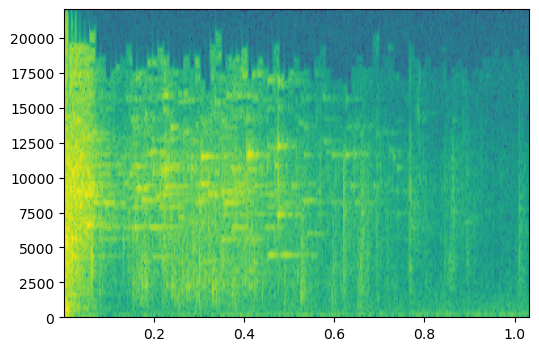

In [135]:
from io import BytesIO

with wave.open(BytesIO(sound_content), 'r') as sound_file:
    frames = sound_file.readframes(-1)
    sampwidth = sound_file.getsampwidth()
    channels = sound_file.getnchannels()
    sound_info = np.frombuffer(frames, dtype='int32')
    frame_rate = sound_file.getframerate()
    plt.figure(figsize=(6,4))
    # plt.axis('off')
    plt.specgram(sound_info, Fs=frame_rate)

with wave.open('test.wav', 'w') as sound_file:
    sound_file.setnchannels(channels)
    sound_file.setsampwidth(sampwidth)
    sound_file.setframerate(frame_rate)
    sound_file.writeframes(frames)

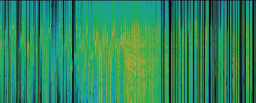

In [153]:
from fastdownload import download_url
from fastai.vision.all import *

glass_break_res = httpx.get('https://freesound.org/apiv2/search/text/?filter=tag:shatter&fields=id,images&token=' + api_key).json()
test_res = glass_break_res['results'][0]

dest = str(test_res['id']) + '.jpg'
download_url(test_res['images']['spectral_bw_m'], dest)
im = Image.open(dest)
im.to_thumb(256,256)

# while glass_break_res['next']:
    # glass_break_ids = glass_break_ids + [sound['id'] for sound in glass_break_res['results']]
    # glass_break_res = httpx.get(glass_break_res['next'] + '&token=' + api_key).json()

In [154]:
glass_break_res = httpx.get('https://freesound.org/apiv2/search/text/?filter=tag:shatter&fields=id,images&token=' + api_key).json()

glass_break_path = Path('./datasets/glass_break_or_not/glass_break/')

while glass_break_res['next']:
    for sound in glass_break_res['results']:
        try:
            download_url(sound['images']['spectral_bw_m'], glass_break_path.joinpath(str(sound['id']) + '.jpg'))
        except Exception:
            continue
    glass_break_res = httpx.get(glass_break_res['next'] + '&token=' + api_key).json()

URLError: <urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>

In [156]:
other_res = httpx.get('https://freesound.org/apiv2/search/text/?fields=id,images,tags&token=' + api_key).json()

other_path = Path('./datasets/glass_break_or_not/not/')

dl_counter = 0
while other_res['next'] and dl_counter < 1000:
    for sound in other_res['results']:
        for tag in sound['tags']:
            if tag not in ['glass', 'shatter', 'break-glass', 'glass-shatter', 'shattering']:
                try:
                    download_url(sound['images']['spectral_bw_m'], other_path.joinpath(str(sound['id']) + '.jpg'))
                    dl_counter = dl_counter + 1
                    break
                except Exception:
                    break
    other_res = httpx.get(other_res['next'] + '&fields=id,images,tags&token=' + api_key).json()

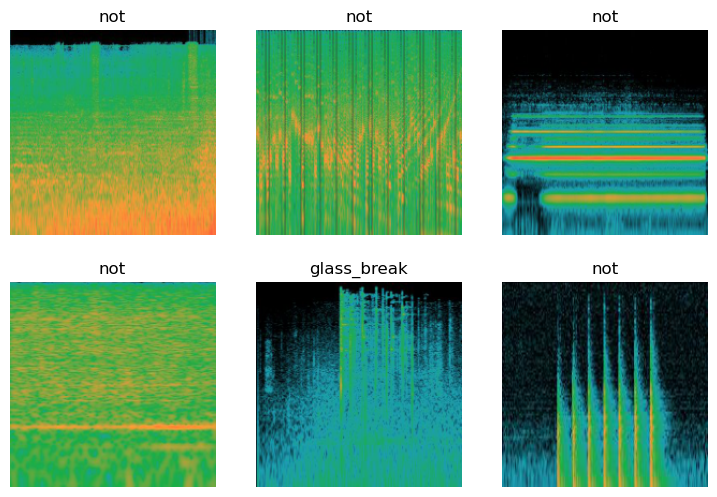

In [163]:
# **NOTE: Needed to set num_workers=0 here for some reason
# Even though it worked previously without this. Windows issue.
# https://github.com/fastai/fastbook/issues/85#issuecomment-614000930
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(Path('./datasets/glass_break_or_not/'), num_workers=0)

dls.show_batch(max_n=6)

In [165]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

c:\Users\Danny\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Danny\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch     train_loss  valid_loss  error_rate  time    
0         1.032089    0.636189    0.267442    00:07                                      
epoch     train_loss  valid_loss  error_rate  time    
0         0.612415    0.543208    0.224806    00:07                                      
1         0.478787    0.457103    0.143411    00:07                                      
2         0.352149    0.407364    0.096899    00:08                                      
3         0.253456    0.385788    0.104651    00:08                                      
4         0.188184    0.361433    0.108527    00:08                                      
5         0.146723    0.358666    0.104651    00:08                                      


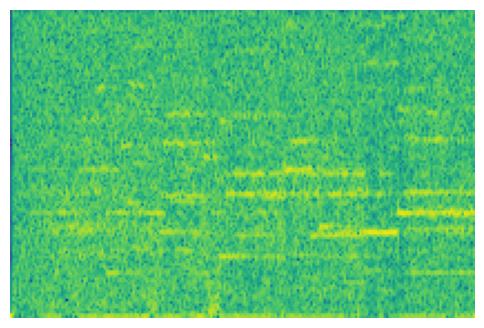

In [172]:
# Get spectrogram from wavefile and save
wave_path = './glass_break_test2.wav'

with wave.open(wave_path, 'r') as sound_file:
    frames = sound_file.readframes(-1)
    sound_info = np.frombuffer(frames, dtype='int8')
    frame_rate = sound_file.getframerate()
    # plt.xlabel('Time [s]')
    # plt.ylabel('Frequency [Hz]')
    plt.figure(figsize=(6,4))
    plt.axis('off')
    plt.specgram(sound_info, Fs=frame_rate)
    plt.savefig(Path(wave_path).parent.joinpath(Path(wave_path).stem + '.png'), bbox_inches='tight')


In [185]:
test_res = httpx.get('https://freesound.org/apiv2/search/text/?filter=id:130853&fields=id,images,tags&token=' + api_key).json()
test_sound = test_res['results'][0]
download_url(test_sound['images']['spectral_bw_m'], './not_glass_break_test_freesound.jpg')

Path('not_glass_break_test_freesound.jpg')

In [186]:
is_glass,_,probs = learn.predict(PILImage.create('./not_glass_break_test_freesound.jpg'))
print(f"This is a: {is_glass}.")
print(f"Probability it's glass breaking {probs[0]:.4f}")

This is a: not.                                                      
Probability it's glass breaking 0.0000


Model seems to work surprisingly well, but only when the spectrogram formatting is identical to the training set.

If we download a random .wav file and convert it to a spectrogram using pyplot, results are bad - but looking at the pyplot spectrograms you can tell they are formatted very differently from the ones downloaded directly from freesound.

Not sure why the spectrograms are different, must be different algorithms used to generate them. Freesound seems to have a lot more blank space, while the pyplot ones are colored throughout (not to mention the white borders, but that's probably the lesser issue.)

If we download unseen spectrograms of glass breaking and other non-glass break sounds from freesound though, model works well.